In [1]:
import argparse
from time import time
import os
import sys
from pathlib import Path
from IPython.display import clear_output, display, Image
import ipywidgets
import traitlets

import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.backends.cudnn as cudnn

# FILE = Path('./')
ROOT = Path('/home/jetbot/yolov5/')  # YOLOv5 root directory
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))  # add ROOT to PATH
ROOT = Path(os.path.relpath(ROOT, Path.cwd()))  # relative

from models.common import DetectMultiBackend
from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, scale_coords, strip_optimizer, xyxy2xywh)
from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, time_sync

from road_follower import RoadFollower

sys.path.append("/home/jetbot/jetbot/")
from jetbot import bgr8_to_jpeg
from jetbot import Camera

import pycuda.driver as cuda
import pycuda.autoinit
import tensorrt as trt
import torch2trt

In [2]:
# Parameters
load_yolo = True
weights = ROOT / 'best.pt'  # model.pt path(s)
source = 0  # file/dir/URL/glob, 0 for webcam
imgsz = [416]  # inference size (pixels)
conf_thres = 0.25  # confidence threshold
iou_thres = 0.45  # NMS IOU threshold
max_det = 1000  # maximum detections per image
device = ''  # cuda device, i.e. 0 or 0,1,2,3 or cpu
view_img = False  # show results
save_txt = False  # save results to *.txt
save_conf = False  # save confidences in --save-txt labels
save_crop = False  # save cropped prediction boxes
nosave = False  # do not save images/videos
classes = None  # filter by class: --class 0, or --class 0 2 3
agnostic_nms = False  # class-agnostic NMS
augment = False  # augmented inference
visualize = False  # visualize features
update = False  # update all models
project = ROOT / 'runs/detect'  # save results to project/name
name = 'exp'  # save results to project/name
exist_ok = False  # existing project/name ok, do not increment
line_thickness = 3  # bounding box thickness (pixels)
hide_labels = False  # hide labels
hide_conf = False  # hide confidences
half = False  # use FP16 half-precision inference
dnn = False  # use OpenCV DNN for ONNX inference

In [3]:
imgsz *= 2 if len(imgsz) == 1 else 1  # expand

In [4]:
source = str(source)
save_img = not nosave and not source.endswith('.txt')  # save inference images
is_file = Path(source).suffix[1:] in (IMG_FORMATS + VID_FORMATS)
is_url = source.lower().startswith(('rtsp://', 'rtmp://', 'http://', 'https://'))
webcam = source.isnumeric() or source.endswith('.txt') or (is_url and not is_file)
if is_url and is_file:
    source = check_file(source)  # download

In [5]:
source

'0'

# Directories
save_dir = increment_path(Path(project) / name, exist_ok=exist_ok)  # increment run
(save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

In [6]:
# Load model
device = select_device(device)
if load_yolo:
    model = DetectMultiBackend(weights, device=device, dnn=dnn)
    stride, names, pt, jit, onnx = model.stride, model.names, model.pt, model.jit, model.onnx
    imgsz = check_img_size(imgsz, s=stride)  # check image size
else:
    stride = 32
    pt = True
    jit = False
    onnx = False
    imgsz = check_img_size(imgsz, s=stride)  # check image size

YOLOv5 🚀 v6.0-85-g96bfaef torch 1.9.0 CUDA:0 (NVIDIA Tegra X1, 3964MiB)

Fusing layers... 
Model Summary: 213 layers, 7031701 parameters, 0 gradients, 15.9 GFLOPs


In [7]:
# Dataloader
# view_img = check_imshow()
cudnn.benchmark = True  # set True to speed up constant image size inference
dataset = LoadStreams(source, img_size=imgsz, stride=stride, auto=pt and not jit)
bs = len(dataset)  # batch_size

1/1: 0...  Success (inf frames 416x416 at 60.00 FPS)



In [8]:
if load_yolo:
    if pt and device.type != 'cpu':
        model(torch.zeros(1, 3, *imgsz).to(device).type_as(next(model.model.parameters())))  # warmup
dt, seen = [0.0, 0.0, 0.0], 0

In [21]:
road_follower = RoadFollower(
    speed=0.375,
    Kp=1.25*0.3, # 1.25
    Kd=0.375/3.0, # 0.75
    Ki=0.0005,
    setpoint=0
)

In [22]:
road_follower.display_monitor_sliders()

FloatSlider(value=0.0, description='y', max=1.0, orientation='vertical')

FloatSlider(value=0.0, description='speed', max=1.0, orientation='vertical')

FloatSlider(value=0.0, description='x', max=1.0, min=-1.0)

FloatSlider(value=0.0, description='steering', max=1.0, min=-1.0)

FloatSlider(value=0.0, description='angle', max=10.0, min=-10.0)

FloatSlider(value=0.0, description='left motor', max=1.0, orientation='vertical')

FloatSlider(value=0.0, description='right motor', max=1.0, orientation='vertical')

In [23]:
errors = []

In [24]:
try:
    conf_thres = 0.40
    # start_total = time()
    for path, im, im0s, vid_cap, s in dataset:
        # t1 = time_sync()
        im = torch.from_numpy(im).to(device)
        im = im.half() if half else im.float()  # uint8 to fp16/32
        im /= 255  # 0 - 255 to 0.0 - 1.0
        if len(im.shape) == 3:
            im = im[None]  # expand for batch dim
        # print("PREPARE IMAGE:", time() - start)
        # t2 = time_sync()
        # dt[0] += t2 - t1
        input_image = im
        # found = {'person': []}
        found = {'person': [], 'stop sign': []}
        if load_yolo:
            # Inference
            # visualize = increment_path(save_dir / Path(path).stem, mkdir=True) if visualize else False
            # start = time()
            pred = model(im, augment=augment, visualize=False)
            # print("PRED YOLO:", time() - start)
            # t3 = time_sync()
            # dt[1] += t3 - t2
            # print("="*50)
            # print("PRED FIRST:\n", pred)

            # NMS
            # start = time()
            pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)
            save_pred = pred
            # print("NMS:", time() - start)
            # print("PRED NMS:\n", pred)
            # print("="*50)
            # dt[2] += time_sync() - t3
            det = pred[0]
            for c in det[:, -1].unique():  # For each class
                n = (det[:, -1] == c).sum()  # detections per class
                s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string
            for *xyxy, conf, c in reversed(det):
                xywh = xyxy2xywh(torch.tensor(xyxy).view(1, 4))
                pred_width = (xywh[:, 2] / (im.shape[-1]))
                found[names[int(c)]].append(pred_width.item())
                print(found)
                print("="*100)
        image = im[0].cpu().permute(1, 2, 0).numpy() * 255
        image = np.asarray(image).astype('uint8').copy()
        # start = time()
        image_roi, error = road_follower.execute(image, found)
        # errors.append(error)
        # print("ROAD FOLLOWER:", time() - start)
        # print("-"*100)
        # print("TOTAL FRAMES:", time() - start_total)
        # cv2.putText(image,str(s),(10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
        # cv2.imshow("Test", image)
        # key = cv2.waitKey(1) & 0xFF
        # if key == ord("q"):
        #     break
        # _, image = cv2.imencode('.jpeg', image_roi)
        # display_handle.update(Image(data=image.tobytes()))
except:
    # stop_total = time()
    road_follower.robot.stop()
    cv2.destroyAllWindows()

{'person': [1.0479954481124878], 'stop sign': []}
REDUCE ROBOTO!!!
{'person': [1.0260212421417236], 'stop sign': []}
REDUCE ROBOTO!!!
{'person': [1.0373386144638062], 'stop sign': []}
REDUCE ROBOTO!!!
{'person': [1.0347113609313965], 'stop sign': []}
REDUCE ROBOTO!!!
{'person': [1.0549204349517822], 'stop sign': []}
REDUCE ROBOTO!!!
{'person': [1.0148965120315552], 'stop sign': []}
REDUCE ROBOTO!!!
{'person': [1.0385932922363281], 'stop sign': []}
REDUCE ROBOTO!!!
{'person': [1.0421020984649658], 'stop sign': []}
REDUCE ROBOTO!!!
{'person': [1.0064817667007446], 'stop sign': []}
REDUCE ROBOTO!!!
{'person': [1.0559366941452026], 'stop sign': []}
REDUCE ROBOTO!!!
{'person': [1.0472441911697388], 'stop sign': []}
REDUCE ROBOTO!!!
{'person': [1.0409820079803467], 'stop sign': []}
REDUCE ROBOTO!!!


In [32]:
save_pred

[tensor([[ 2.82211e-02, -9.97353e-01,  1.84216e+02,  2.05567e+02,  5.06744e-01,  0.00000e+00]], device='cuda:0')]

In [22]:
xyxy = save_pred[0][:, :4]

In [31]:
xyxy2xywh(torch.tensor(xyxy).view(1, 4))[:, 2]

/home/jetbot/.virtualenvs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


tensor([True], device='cuda:0')

In [ ]:
xyxy2xywh

In [14]:
road_follower.robot.stop()

In [136]:
stop_total - start_total

2.3333282470703125

In [53]:
_, image = cv2.imencode('.jpeg', image_roi)
display_handle.update(Image(data=image.tobytes()))

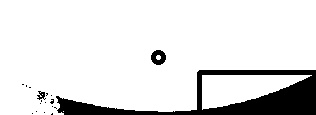

In [10]:
display_handle = display(None, display_id=True)

In [51]:
image.shape

(416, 416, 3)

In [41]:
plt.imsave('original.png', image)

In [45]:
%matplotlib inline
plt.scatter(image_roi)
plt.show()

TypeError: scatter() missing 1 required positional argument: 'y'

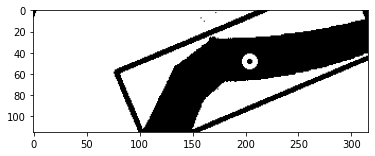

In [48]:
%matplotlib inline
fig = plt.figure()
plt.imshow(image_roi, cmap='gray', figure=fig)
plt.savefig('roi.png')
plt.show()

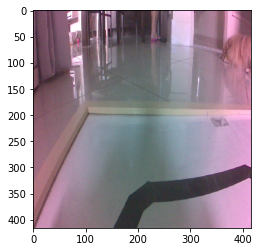

In [50]:
%matplotlib inline
fig = plt.figure()
plt.imshow(image, figure=fig)
plt.savefig('original.png')
plt.show()

In [107]:
errors = np.asarray(errors)

mean = [errors.mean()]*len(errors)

std = [errors.std()]*len(errors)

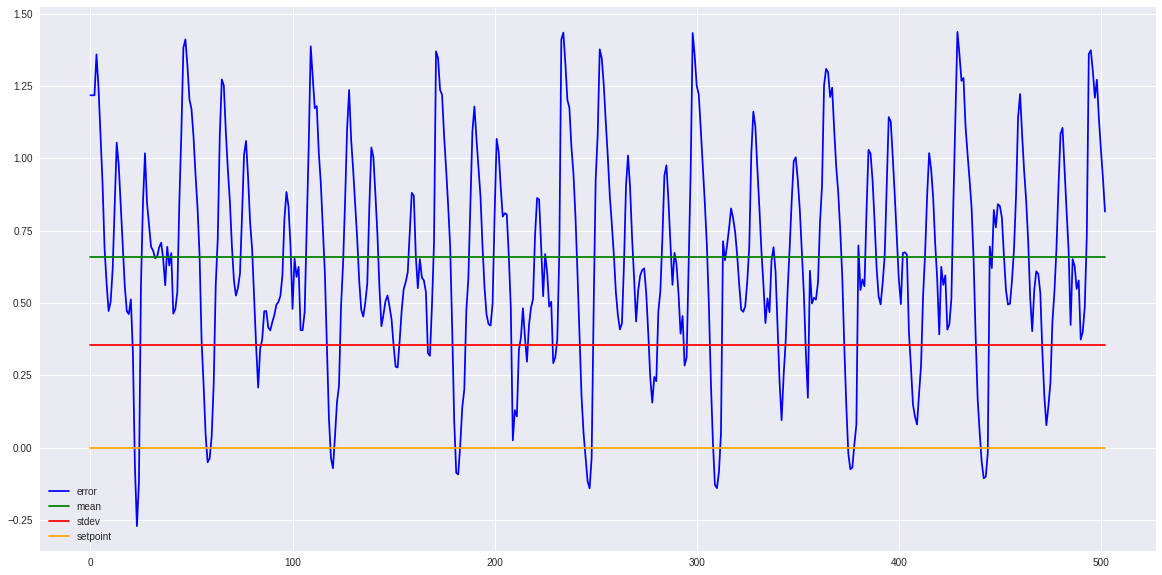

In [108]:
%matplotlib inline
plt.style.use('seaborn')
fig = plt.figure(figsize=(20,10))
plt.plot(errors, figure=fig, color='blue')
plt.plot(mean, figure=fig, color='green')
plt.plot(std, figure=fig, color='red')
plt.plot([0]*len(errors), figure=fig, color='orange')
plt.legend(['error', 'mean', 'stdev', 'setpoint'])
plt.show()

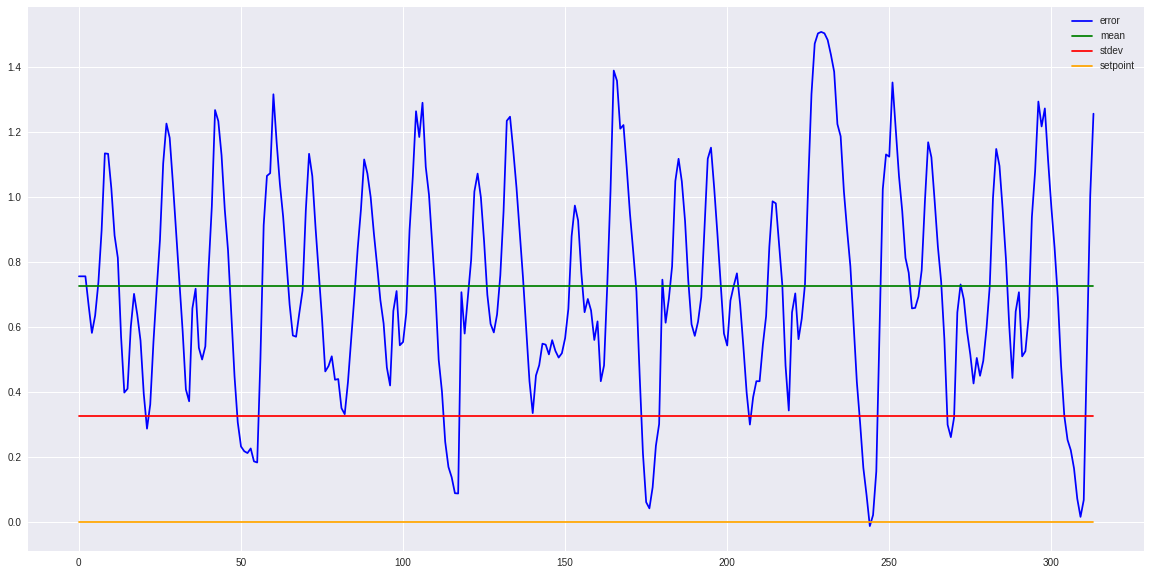

In [103]:
%matplotlib inline
plt.style.use('seaborn')
fig = plt.figure(figsize=(20,10))
plt.plot(errors, figure=fig, color='blue')
plt.plot(mean, figure=fig, color='green')
plt.plot(std, figure=fig, color='red')
plt.plot([0]*len(errors), figure=fig, color='orange')
plt.legend(['error', 'mean', 'stdev', 'setpoint'])
plt.show()

In [39]:
road_follower.robot.stop()

In [16]:
image = ipywidgets.widgets.Image(format='jpeg', width=208, height=208)

display(image)

Image(value=b'', format='jpeg', height='208', width='208')

In [17]:
camera_link = traitlets.dlink((cap, 'value'), (image, 'value'), transform=bgr8_to_jpeg)

In [1]:
import cv2
from IPython.display import clear_output, display, Image
import ipywidgets
import traitlets
import numpy as np

import sys
sys.path.append("/home/jetbot/jetbot/")
from jetbot import Camera
from jetbot import bgr8_to_jpeg

In [203]:
def union(a,b):
    x = min(a[0], b[0])
    y = min(a[1], b[1])
    w = max(a[0]+a[2], b[0]+b[2]) - x
    h = max(a[1]+a[3], b[1]+b[3]) - y
    return (x, y, w, h)

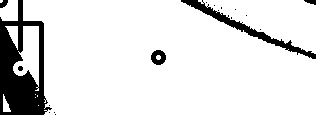

In [2]:
camera = Camera.instance(
    width=416,
    height=416,
    fps=60,
    capture_width=1280,
    capture_height=720)
display_handle = display(None, display_id=True)

In [340]:
image = camera.value
width = 50
height = 300
roi = [[height,-1],[width,-width]]
image = image[roi[0][0]:roi[0][1], roi[1][0]:roi[1][1]]
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
(thresh, image) = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY)
print("THRESHOLD:", thresh)
Blackline = cv2.inRange(image, 0, thresh)
kernel = np.ones((3,3), np.uint8)
Blackline = cv2.erode(Blackline, kernel, iterations=5)
Blackline = cv2.dilate(Blackline, kernel, iterations=9)	
contours_blk, hierarchy_blk = cv2.findContours(Blackline.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

contours_blk_len = len(contours_blk)
x, y = 0, 0
if contours_blk_len > 0 :
    if contours_blk_len == 1 :
        blackbox = cv2.minAreaRect(contours_blk[0])
    else:
        for c in contours_blk:
            blackbox = cv2.minAreaRect(c)
            (x_min, y_min), (w_min, h_min), ang = blackbox
            x += x_min
            y += y_min
        x = x / contours_blk_len
        y = y / contours_blk_len
        # canditates=[]
        # off_bottom = 0
        # for con_num in range(contours_blk_len):
        #     blackbox = cv2.minAreaRect(contours_blk[con_num])
        #     (x_min, y_min), (w_min, h_min), ang = blackbox		
        #     box = cv2.boxPoints(blackbox)
        #     (x_box,y_box) = box[0]
        #     if y_box > 358 :
        #         off_bottom += 1
        #     canditates.append((y_box,con_num,x_min,y_min))
        # canditates = sorted(canditates)
        # if off_bottom > 1:
        #     canditates_off_bottom=[]
        #     for con_num in range ((contours_blk_len - off_bottom), contours_blk_len):
        #         (y_highest,con_highest,x_min, y_min) = canditates[con_num]		
        #         total_distance = (abs(x_min - x_last)**2 + abs(y_min - y_last)**2)**0.5
        #         canditates_off_bottom.append((total_distance,con_highest))
        #     canditates_off_bottom = sorted(canditates_off_bottom)         
        #     (total_distance,con_highest) = canditates_off_bottom[0]         
        #     blackbox = cv2.minAreaRect(contours_blk[con_highest])	   
        # else:
        #     (y_highest,con_highest,x_min, y_min) = canditates[contours_blk_len-1]
        #     blackbox = cv2.minAreaRect(contours_blk[con_highest])
    # print(blackbox.shape)
    # print(blackbox)
    (x_min, y_min), (w_min, h_min), ang = blackbox
    box = cv2.boxPoints(blackbox)
    box = np.int0(box)
    cv2.drawContours(image,[box],0,(0,0,0),3)
    cv2.line(image, (int(x_min),0 ), (int(x_min),50 ), (0,0,0),3)
    cv2.circle(image, (image.shape[1]//2, image.shape[0]//2), 5, (0,0,0), 3)
    cv2.circle(image, (int(x_min), int(y_min)), 5, (255,255,255), 3)
    cv2.circle(image, (int(x),int(y)), 5, (0,0,0), 3)
xy = [
    (x_min - image.shape[1]/2.0) / (image.shape[1]/2.0),
    -(y_min - image.shape[0]) / image.shape[0]
]
_, image = cv2.imencode('.jpeg', image)
display_handle.update(Image(data=image.tobytes()))

THRESHOLD: 100.0


In [201]:
x, y = xy[0], xy[1]

In [10]:
print(xy)

[-0.8639240506329114, 0.11304347826086956]


In [11]:
np.arctan2(x, y)

-1.4406866595745658

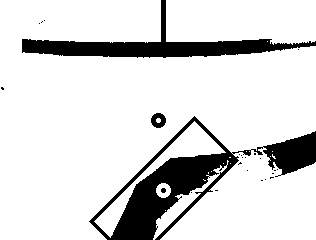

In [ ]:
x_last = 0
y_last = 0
try:
    display_handle = display(None, display_id=True)
    while True:
        image = camera.value
        # print(image.shape)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        roi = [[175,-1],[50,-50]]
        image = image[roi[0][0]:roi[0][1], roi[1][0]:roi[1][1]]
        # image = image[300:415, :]  # Region Of Interest
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # print(image.shape)
        # (thresh, image) = cv2.threshold(image, 220, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        (thresh, image) = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY)
        # print("THRESHOLD:", thresh)
        # Blackline = cv2.inRange(image, (0,0,0), (self.threshold,self.threshold,self.threshold))
        Blackline = cv2.inRange(image, 0, thresh)
        kernel = np.ones((3,3), np.uint8)
        Blackline = cv2.erode(Blackline, kernel, iterations=5)
        Blackline = cv2.dilate(Blackline, kernel, iterations=9)	
        contours_blk, hierarchy_blk = cv2.findContours(Blackline.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

        contours_blk_len = len(contours_blk)
        if contours_blk_len > 0 :
            if contours_blk_len >= 1 :
                blackbox = cv2.minAreaRect(contours_blk[0])
            else:
                canditates=[]
                off_bottom = 0	   
                for con_num in range(contours_blk_len):		
                    blackbox = cv2.minAreaRect(contours_blk[con_num])
                    (x_min, y_min), (w_min, h_min), ang = blackbox		
                    box = cv2.boxPoints(blackbox)
                    (x_box,y_box) = box[0]
                    if y_box > 358 :		 
                        off_bottom += 1
                    canditates.append((y_box,con_num,x_min,y_min))		
                canditates = sorted(canditates)
                if off_bottom > 1:	    
                    canditates_off_bottom=[]
                    for con_num in range ((contours_blk_len - off_bottom), contours_blk_len):
                        (y_highest,con_highest,x_min, y_min) = canditates[con_num]		
                        total_distance = (abs(x_min - x_last)**2 + abs(y_min - y_last)**2)**0.5
                        canditates_off_bottom.append((total_distance,con_highest))
                    canditates_off_bottom = sorted(canditates_off_bottom)         
                    (total_distance,con_highest) = canditates_off_bottom[0]         
                    blackbox = cv2.minAreaRect(contours_blk[con_highest])	   
                else:		
                    (y_highest,con_highest,x_min, y_min) = canditates[contours_blk_len-1]
                    blackbox = cv2.minAreaRect(contours_blk[con_highest])
            (x_min, y_min), (w_min, h_min), ang = blackbox
            box = cv2.boxPoints(blackbox)
            box = np.int0(box)
            cv2.drawContours(image,[box],0,(0,0,0),3)
            cv2.line(image, (int(x_min),0 ), (int(x_min),50 ), (0,0,0),3)
            cv2.circle(image, (image.shape[1]//2, image.shape[0]//2), 5, (0,0,0), 3)
            cv2.circle(image, (int(x_min), int(y_min)), 5, (255,255,255), 3)
        _, image = cv2.imencode('.jpeg', image)
        display_handle.update(Image(data=image.tobytes()))
            # cv2.imshow("Test", image)
            # key = cv2.waitKey(1) & 0xFF
            # if key == ord("q"):
            #     break
except:
    camera.stop()
    cv2.destroyAllWindows()